<a href="https://colab.research.google.com/github/Smartsie/Invest/blob/master/Invest_with_Currency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## External lib imports

In [1]:
!pip install investpy 
#==0.9.14

     |████████████████████████████████| 4.4MB 5.5MB/s 
     |████████████████████████████████| 245kB 36.3MB/s 
     |████████████████████████████████| 5.5MB 30.1MB/s 
     |████████████████████████████████| 512kB 45.9MB/s 
  Created wheel for investpy: filename=investpy-1.0.1-cp36-none-any.whl size=4473067 sha256=3dbc087f6e78d898603aab676b58ea081c5068f74f094a4c675493fb42ff0ac2
  Stored in directory: /root/.cache/pip/wheels/ff/19/7e/2df70c2cd442e209c3c4a2d07dbd34889bc84588a1885a6a2c
Successfully built investpy
ERROR: convertdate 2.2.0 has requirement pytz<2020,>=2014.10, but you'll have pytz 2020.5 which is incompatible.
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Found existing installation: pytz 2018.9
    Uninstalling pytz-2018.9:
      Successfully uninstalled pytz-2018.9


# Libraries Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import investpy

In [3]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [5]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
parameters = {'max_depth':[3,4,5], 'n_estimators':[500]}

## Data Import

In [76]:
Index='EUR/USD'
data = investpy.get_currency_cross_historical_data(currency_cross=Index,from_date='01/01/2000', to_date='29/01/2021')
data=data.drop(['Currency'],axis=1)
data.tail()

,Open,High,Low,Close
Date,,,,
2021-01-25,1.2168,1.2184,1.2115,1.2137
2021-01-26,1.2138,1.2177,1.2107,1.2160
2021-01-27,1.2160,1.2170,1.2057,1.2108
2021-01-28,1.2109,1.2142,1.2079,1.2121
2021-01-29,1.2121,1.2156,1.2093,1.2136


Feature Engineering


1.   Add Daily percent variation (Close.today/Close.yesterday)
2.   -



In [75]:
# Calculate daily percentage variation
data['daily perc']=data.Close/data.Close.shift(1)
data=data.dropna(axis=0)

In [77]:
# Calculate candle ratio
# (Close-open)/(Max-Min)
# Candle =0 no big variation
# candle =+1: big variation up.Open=low and High=Close
# candle = -1: big variation down. Open=High.Close=Low
data['candle']=(data.Close-data.Open)/(data.High-data.Low)

In [78]:
data.head()

,Open,High,Low,Close,candle
Date,,,,,
2000-01-03,1.0052,1.0282,1.0050,1.0265,0.918103
2000-01-04,1.0244,1.0347,1.0213,1.0312,0.507463
2000-01-05,1.0295,1.0404,1.0282,1.0316,0.172131
2000-01-06,1.0325,1.0419,1.0275,1.0324,-0.006944
2000-01-07,1.0327,1.0333,1.0252,1.0292,-0.432099


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e1eb9c860>,
      dtype=object)

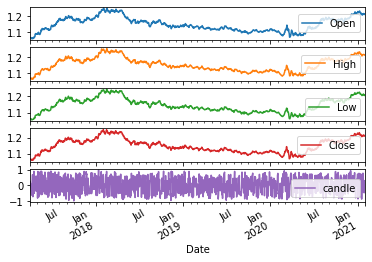

In [79]:
data[-1000:].plot(subplots=True)

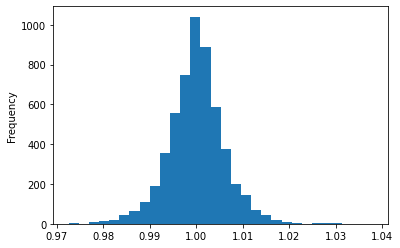

In [10]:
# plot distribution
data['daily perc'].plot(kind='hist',bins=30)

In [11]:
data.describe()

,Open,High,Low,Close,daily perc
count,5499.000000,5499.000000,5499.000000,5499.000000,5499.000000
mean,1.206346,1.211858,1.200857,1.206439,1.000049
std,0.163154,0.163749,0.162486,0.163124,0.006028
min,0.826800,0.832600,0.822700,0.827300,0.972573
25%,1.109350,1.114100,1.106250,1.109950,0.996611
50%,1.214200,1.219000,1.208700,1.214300,1.000076
75%,1.325850,1.332300,1.319200,1.325800,1.003362
max,1.600000,1.603900,1.586500,1.598800,1.038039


# XGBoost Model


In [ ]:
# Generate Dataset
lookback=20
horizon=4
X=[]
y=[]
for i in range(lookback,len(data)-horizon):
  data1=data['Open'].iloc[i-lookback:i].values
  data2=data['Close'].iloc[i-lookback:i].values
  data3=data['High'].iloc[i-lookback:i].values
  data4=data['Low'].iloc[i-lookback:i].values
  #perc=data['daily perc'].iloc[i-lookback:i].values
  target=data['Low'].iloc[i+horizon]
  X.append(np.array([data1,data2,data3,data4]).ravel())
  
  y.append(target)
y=np.array(y).reshape(-1,1)

In [ ]:
# Data Scaling
scaler=MinMaxScaler()
scaler.fit(np.array(y))
X_=scaler.transform(X)
y_=scaler.transform(y)
X_train,X_test,y_train,y_test=train_test_split(X_,y_,shuffle=True,test_size=0.2)

In [ ]:
model=xgb.XGBRegressor(objective='reg:squarederror',scoring='mse',max_depth=5,n_estimators=500)

In [ ]:
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             scoring='mse', seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
# For performing Gridsearch
grid = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror',scoring='mse'), parameters,cv=3)

In [ ]:
#model = xgb.XGBRegressor(max_depth=4,n_estimators=500,objective='reg:squarederror') 
grid.fit(X_,y_)

KeyboardInterrupt: ignored

In [ ]:
plt.plot(model.feature_importances_)

In [ ]:
print("Training score ",model.score(X_train,y_train))
print("Testing scofe ",model.score(X_test,y_test))
rmse=np.sqrt(mean_squared_error(y_test,model.predict(X_test)))
print("Rmse ",rmse)

In [ ]:
erreur=cours_predit-cours_actuel
plt.plot(erreur,color='blue')
#plt.fill_between(np.arange(0,len(erreur)),np.array(erreur+erreur_min).ravel(),np.array(erreur+erreur_max).ravel())
plt.show()

In [ ]:
plt.hist(erreur,bins=50)
plt.show()
erreur_min=np.percentile(erreur,2.5)
erreur_max=np.percentile(erreur,97.5)
print("Intervalle de confiance ",erreur_min, erreur_max)

In [ ]:
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)
r2=r2_score(y_test, y_pred_test)
plt.scatter(scaler.inverse_transform(y_pred_train.reshape(-1,1)),scaler.inverse_transform(y_train),color='blue',alpha=0.05,label='train data')
plt.scatter(scaler.inverse_transform(y_pred_test.reshape(-1,1)),scaler.inverse_transform(y_test),color='red',alpha=0.05,label='test data')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.title("Prediction vs Actual. R2 score=%0.2f"%r2)
plt.legend()
plt.show()

In [ ]:
y_pred=model.predict(X_).reshape(-1,1)
n_plot=25
cours_actuel=scaler.inverse_transform(y_[-n_plot:])
cours_predit=scaler.inverse_transform(y_pred[-n_plot:])
plt.plot(cours_actuel,color='blue',label='actual',alpha=0.8)
plt.plot(cours_predit,color='red',label='predicted',alpha=0.5)
#plt.fill_between(np.arange(0,len(cours_predit)),np.array(cours_predit+erreur_min).ravel(),np.array(cours_predit+erreur_max).ravel(),alpha=0.5)
plt.legend()
plt.show()

In [ ]:
pred=scaler.inverse_transform(model.predict(X_[-horizon:]).reshape(-1,1))
print("Prediction for the next 5 days")
pred=pd.DataFrame(pred,columns=["Prediction"])
pred.index=['tomorrow','t+2','t+3','t+4']
print(pred)

In [ ]:
pred.plot()

In [ ]:
# Predict in the last N days of known 
N=5
X_horiz=[]
for i in range(len(data)-horizon-N,len(data)-horizon):
  data1=data['Close'].iloc[i-lookback:i].values
  data2=data['daily perc'].iloc[i-lookback:i].values
  X_horiz.append(np.append(data1,data2))
X_to_predict=scaler.transform(X_horiz)
y_predicted=model.predict(X_to_predict)
y_predicted=scaler.inverse_transform(y_predicted)

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
N_days=50 # How many days to look back
y_pred_lookback=scaler.inverse_transform(model.predict(X_[-N_days:]))
plt.plot(np.append(y_pred_lookback,y_predicted),color='red',label='prediction')
plt.plot(y[-N_days-horizon:-horizon],color='black',label='actual')
plt.legend()
plt.title('EUR/USD +1d %0.3f'%y_predicted[0]+' +2d %0.3f'%y_predicted[1]+' +3d %0.3f'%y_predicted[2]+' +4d %0.3f'%y_predicted[3]+' +5d %0.3f'%y_predicted[4])
plt.show()


# Random Walk

0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



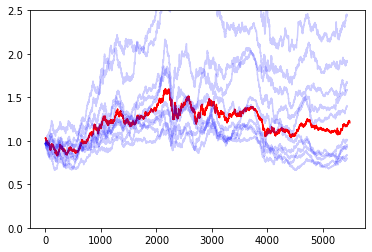

In [ ]:
# Random Walk method
plt.plot(data.Close.values,color='red')
plt.ylim((0,2.5))
N_start=50
df=data
for j in range (0,10):
  initial_stock=data['Close'].iloc[N_start]
  cours=np.array([initial_stock])
  df['T'+str(j)]=0
  print(j)
  for i in range(N_start,len(data)):
    # pick a random variation 
    perc=data['daily perc'][i-N_start:i].sample()
    cours=np.append(cours,cours[-1]*perc)
    df['T'+str(j)].iloc[i]=cours[-1]
  plt.plot(cours,color='blue',alpha=0.2)
plt.show() 


In [ ]:
# Calculate 95% percentile
df['lower']=0
df['median']=0
df['upper']=0
for j in range (0,len(df)):
  lower, median, upper=np.percentile(df.iloc[j][7:],[2.5,50,97.5])
  df['lower'].iloc[j]=lower
  df['median'].iloc[j]=median
  df['upper'].iloc[j]=upper

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



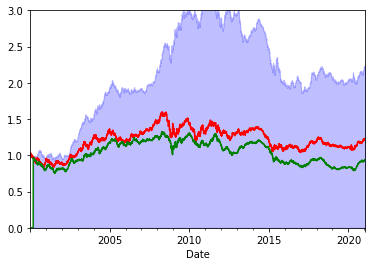

In [ ]:
df['Close'].plot(color='red')
plt.ylim((0,3))
df['median'].plot(color='green')
plt.fill_between(df.index,df['lower'],df['upper'],color='blue',alpha=0.25)
plt.show()

In [ ]:
# Extrapolate for n days using data from last N_start days
def extrapol(N_start=100,n=5):
  N_start=100
  n_traces=5000# how many traces we want
  df=data
  n=5 # amount of days to extrapolate
  X=pd.DataFrame()
  percent=df['daily perc'][-N_start:].values.tolist()
  for j in range(0,n_traces): # How many traces we generate
    cours=np.array([df.Close[-1]])
    for i in range(0,n):
      # pick a sample variation
      perc=np.random.choice(percent) #[i:])
      cours=np.append(cours,cours[-1]*perc)
      percent.append(perc)
    X['T'+str(j)]=cours 
    # Calculate 95% percentile
  X['lower']=0
  X['median']=0
  X['upper']=0
  for j in range (0,len(X)):
    lower, median, upper=np.percentile(X.iloc[j][0:],[5,50,97.5])
    X['lower'].iloc[j]=lower
    X['median'].iloc[j]=median
    X['upper'].iloc[j]=upper
  # Plot the extrapolation
  #plt.ylim((0,150))
  #X['median'].plot(color='green')
  #plt.ylim((df.Open[-1]*0.95,df.Open[-1]*1.05))
  #plt.fill_between(X.index,X['lower'],X['upper'],color='blue',alpha=0.25)
  #plt.show()
  prediction=X.iloc[-1][0:n_traces]
  med=np.percentile(prediction, 50)
  return med

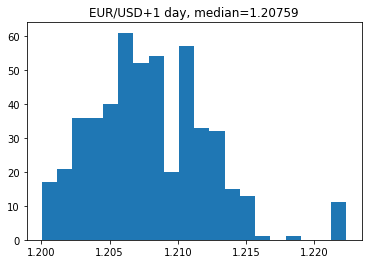

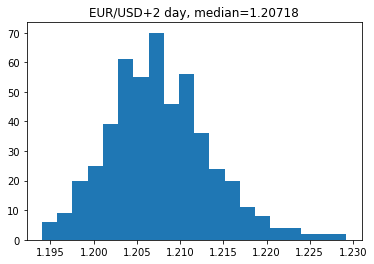

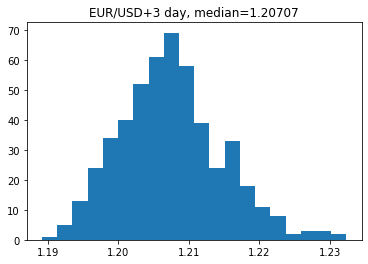

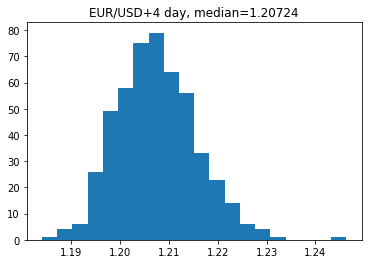

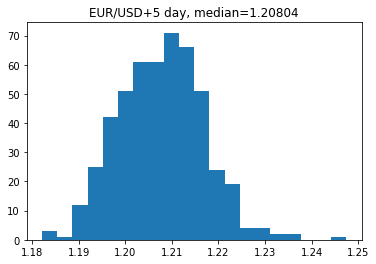

In [ ]:
for i in range(1,6+0*len(X)):
  prediction=X.iloc[i][0:n_traces]
  med=np.percentile(prediction, 50)
  plt.title(Index+'+'+str(i)+' day, median=%0.5f'%med)
  plt.hist(prediction,bins=20)
  plt.show()

# LSTM Model

Très très largement inspiré de https://keras.io/examples/timeseries/timeseries_weather_forecasting/

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator

In [109]:
data=data[['Close','candle']]

In [123]:
def visualize_loss(history, title):
    loss = history.history["loss"][3:]
    val_loss = history.history["val_loss"][3:]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


In [111]:
scalerX=MinMaxScaler()
scalery=MinMaxScaler()
scalerX.fit(data)
scalery.fit(data.Close.values.reshape(-1,1))


MinMaxScaler(copy=True, feature_range=(0, 1))

In [112]:
data_scaled=pd.DataFrame(scalerX.transform(data),columns=data.columns)
data_scaled.index=data.index

In [113]:
past=20
future=4
train_split=5000
batch_size=32
sequence_length=past

X=data_scaled
y=data_scaled['Close']

X_train=X[:train_split]
X_test=X[train_split+1:]
y_train=y[:train_split]
y_test=y[train_split+1:]

In [114]:
train_dataset = TimeseriesGenerator(X_train, y_train, length=past, batch_size=128)
test_dataset = TimeseriesGenerator(X_test, y_test, length=past, batch_size=128)
inputs, targets = train_dataset[0]
print("Input shape:", inputs.shape)
print("Target shape:", targets.shape)
#inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))

Input shape: (128, 20, 2)
Target shape: (128,)


In [115]:
def LSTM_model():
    input_layer = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
    lstm_out = keras.layers.GRU(32,return_sequences=True,activation='relu')(input_layer)
    lstm_out = keras.layers.GRU(32,activation='relu')(lstm_out)
    #lstm_out=keras.layers.Dense(8,activation='relu')(lstm_out)
    outputs = keras.layers.Dense(1,activation='relu')(lstm_out)
    model = keras.Model(inputs=input_layer, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    model.summary()
    return model

In [117]:
def Conv1d_model():
    input_layer = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
    conv1=keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
    conv2=keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(conv1)
    dropout=keras.layers.Dropout(0.02)(conv2)
    pool=keras.layers.AveragePooling1D(pool_size=2)(dropout)
    flat=keras.layers.Flatten()(pool)
    dense=keras.layers.Dense(50, activation='relu')(flat)
    outputs = keras.layers.Dense(1,activation='relu')(dense)
    model = keras.Model(inputs=input_layer, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    model.summary()
    return model

In [141]:
def hybrid_model():
    input_layer = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
    conv1=keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
    conv2=keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(conv1)
    pool=keras.layers.AveragePooling1D(pool_size=2)(conv2)
    #flat=keras.layers.Flatten()(pool)
    gru = keras.layers.GRU(32,return_sequences=True,activation='relu')(pool)
    #dense=keras.layers.Dense(50, activation='relu')(flat)
    outputs = keras.layers.Dense(1,activation='relu')(gru)
    model = keras.Model(inputs=input_layer, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    model.summary()
    return model

In [142]:
model=hybrid_model()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 20, 2)]           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 18, 32)            224       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16, 64)            6208      
_________________________________________________________________
average_pooling1d_5 (Average (None, 8, 64)             0         
_________________________________________________________________
gru_5 (GRU)                  (None, 8, 32)             9408      
_________________________________________________________________
dense_18 (Dense)             (None, 8, 1)              33        
Total params: 15,873
Trainable params: 15,873
Non-trainable params: 0
_______________________________________________________

In [129]:
model=Conv1d_model()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 20, 2)]           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 18, 32)            224       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 16, 64)            6208      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 64)            0         
_________________________________________________________________
average_pooling1d_2 (Average (None, 8, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2565

In [130]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 20, 2)]           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 18, 32)            224       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 16, 64)            6208      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 64)            0         
_________________________________________________________________
average_pooling1d_2 (Average (None, 8, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2565

In [143]:
history=model.fit(train_dataset,epochs=200,validation_data=test_dataset)

Epoch 1/200
39/39 [==============================] - 3s 43ms/step - loss: 0.2075 - val_loss: 0.0075
Epoch 2/200
39/39 [==============================] - 1s 34ms/step - loss: 0.0115 - val_loss: 0.0017
Epoch 3/200
39/39 [==============================] - 1s 34ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 4/200
39/39 [==============================] - 1s 33ms/step - loss: 0.0017 - val_loss: 7.3199e-04
Epoch 5/200
39/39 [==============================] - 1s 35ms/step - loss: 0.0012 - val_loss: 7.1599e-04
Epoch 6/200
39/39 [==============================] - 1s 36ms/step - loss: 0.0013 - val_loss: 4.6892e-04
Epoch 7/200
39/39 [==============================] - 1s 35ms/step - loss: 0.0011 - val_loss: 7.1192e-04
Epoch 8/200
39/39 [==============================] - 1s 35ms/step - loss: 0.0011 - val_loss: 3.9145e-04
Epoch 9/200
39/39 [==============================] - 1s 35ms/step - loss: 9.4473e-04 - val_loss: 3.7706e-04
Epoch 10/200
39/39 [==============================] - 1s 34ms/step - los

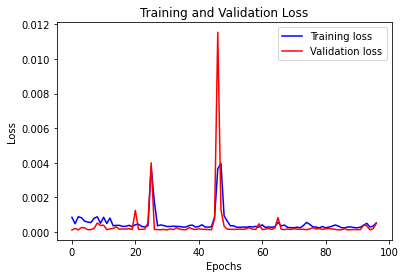

In [132]:
visualize_loss(history, "Training and Validation Loss")

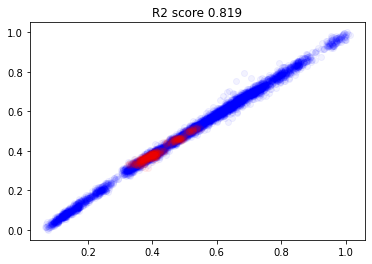

In [133]:
pred_train=model.predict(train_dataset)
pred_test=model.predict(test_dataset)
plt.scatter(pred_train,y_train[past:],alpha=0.05,color='blue')
plt.scatter(pred_test,y_test[past:],alpha=0.05,color='red')
plt.title("R2 score %0.3f"%r2_score(y_test[past:],pred_test))
plt.show()

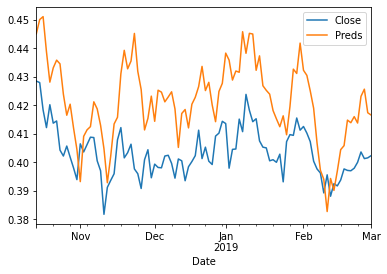

In [134]:
results_train=pd.DataFrame(y_train[past:])
results_train['Preds']=pred_train
results_train.iloc[-100:].plot()

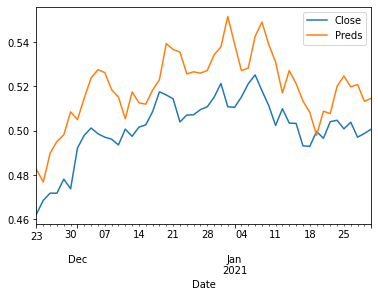

In [135]:
results_test=pd.DataFrame(y_test[past:])
results_test['Preds']=pred_test
results_test.iloc[-50:].plot()

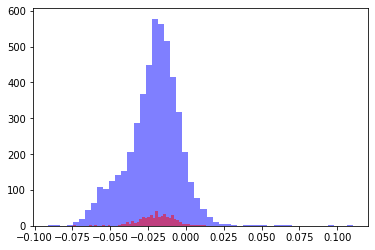

In [136]:
error_train=y_train[past:].values.ravel()-pred_train.ravel()
error_test=y_test[past:].values.ravel()-pred_test.ravel()
plt.hist(error_train,bins=50,color='blue',alpha=0.5)

plt.hist(error_test,bins=50,color='red',alpha=0.5)
plt.show()

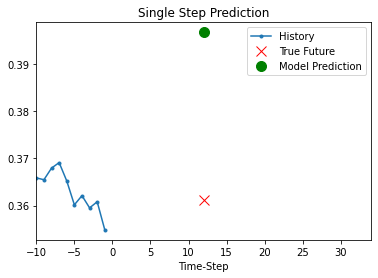

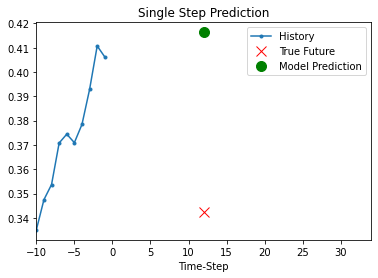

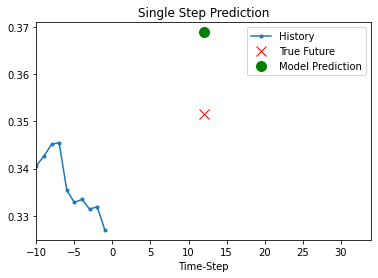

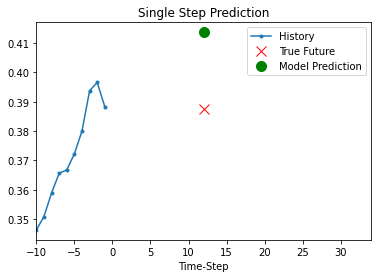

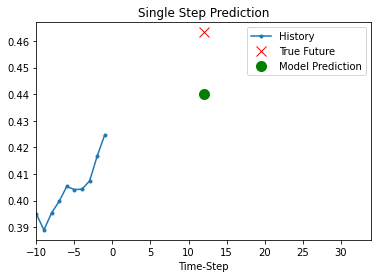

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

In [ ]:
for batch in dataset_train.take(1):
  model.predict(print(batch[0][0]))

tf.Tensor(
[[0.23072944 0.25359782 0.23867505 0.25819831]
 [0.2555613  0.26202515 0.26001571 0.26429034]
 [0.26215727 0.26941527 0.26904949 0.26480881]
 [0.26603725 0.27136004 0.26813302 0.26584576]
 [0.26629591 0.26021004 0.26512176 0.26169799]
 [0.26125194 0.2563205  0.26001571 0.25716137]
 [0.25750129 0.2613769  0.26368159 0.26727155]
 [0.26564925 0.26500713 0.26590731 0.26429034]
 [0.26422659 0.25852457 0.26315789 0.25677252]
 [0.25775996 0.25243096 0.24666143 0.2404407 ]], shape=(10, 4), dtype=float64)


ValueError: ignored

In [ ]:
y_pred=model.predict(x_val[0].reshape(1,20,4))

ValueError: ignored

In [ ]:
np.shape(x_train)

(5225, 4)

In [ ]:
y_pred=[]
y_target=[]
for batch in dataset_val.take(100):
  x,y=batch
  y_target.append(y.numpy())
  y_pred.append(model.predict(x[0]))
y_pred=np.array(y_pred).ravel()
y_target=np.array(y_target).ravel()

ValueError: ignored

In [ ]:
x,y=dataset_val.take(0)
model.predict(x[0])

ValueError: ignored

In [ ]:
model.predict(x_train[0].expand_dim(1))

AttributeError: ignored

In [ ]:
x,y=batch

ValueError: ignored